In [1]:
import matplotlib as mpl
from matplotlib import rc
mpl.use("svg")
from pathlib import Path
from IPython.display import display, Image, SVG

In [2]:
from matplotlib.backends.backend_svg import FigureCanvasSVG# as FigureCanvas
from matplotlib.backends.backend_agg import FigureCanvasAgg #as FigureCanvas
from matplotlib import gridspec
from matplotlib.figure import Figure
from datetime import datetime
import os.path
import numpy as np
import pandas as pd

In [116]:
# Read BoM Climate Data zipped all data export


def read_bom_climatedata_csv_idcjac0009(data_fn):
    """Read BoM Climate Data CSV (IDCJAC0009)
    
    Args:
        data_fn (str): filename
    
    Returns: dataframe with columns "date" (pd.Timestamp) and "rain_mm" (float).
    
    """
    rawdf = pd.read_csv(data_fn)
    rawdf = rawdf.rename(columns={"Bureau of Meteorology station number": "station_no", "Rainfall amount (millimetres)": "rain_mm",
                           "Period over which rainfall was measured (days)": "rain_days"})
    rawdf["date_temp"] = rawdf.Year.astype(str) + "-" + rawdf.Month.astype(str) + "-" + rawdf.Day.astype(str)
    rawdf["date"] = pd.to_datetime(rawdf["date_temp"], format="%Y-%m-%d")
    rawdf = rawdf.drop(["date_temp", "Year", "Month", "Day"], axis=1)
    return rawdf[["date", "rain_mm"]].copy()

In [117]:
# Read SILO data file.

def read_siloppd_txt(data_fn):
    """Read SILO PPD text file.
    
    Args:
        data_fn (str): filename
    
    Returns: tuple of `(rawdf, station)` where `rawdf` is a dataframe 
        with columns "date" (pd.Timestamp) and "rain_mm" (float).
        And `station` is a string with the station name.
    
    """
    with open(data_fn, "r") as f:
        i = 0
        for line in f:
            if i == 13:
                station = line[42:83].strip()
            if line.startswith("Date"):
                skiprows = i
                break
            i += 1

    rawdf = pd.read_csv(data_fn, delim_whitespace=True, skiprows=list(range(skiprows)) + [skiprows + 1])
    rawdf["date"] = pd.to_datetime(rawdf.Date, format="%Y%m%d")
    rawdf["rain_mm"] = rawdf.Rain.astype(float)
    return rawdf[["date", "rain_mm"]].copy(), station

In [146]:
def complete_rainfall_dataset(rawdf):
    """Complete a rainfall dataframe.
    
    Args:
        df (dataframe): columns "date" (pd.Timestamp) and "rain_mm" (float)
        
    Returns: dataframe with columns:
        - date (pd.Timestamp)
        - year (int)
        - month (int)
        - day (int)
        - yearmonthday (tuple of `(year, month, day)`)
        - yearmonth (tuple of `(year, month)`)
        - rain_mm (float)
    
    note that the returned dataframe has been reindexed so that the dates
    form a continuous set of dates at daily period with no gaps.
    
    """
    all_dates = pd.date_range(start=rawdf.date.min(), end=rawdf.date.max(), freq="D")
    df = rawdf.set_index("date").reindex(all_dates)
    df.index.name = "date"
    df = df.reset_index()[["date", "rain_mm"]]
    df["year"] = df.date.dt.year
    df["month"] = df.date.dt.month
    df["day"] = df.date.dt.day
    df["dayofyear"] = df.date.dt.dayofyear
    df["yearmonth"] = list(zip(df.year, df.month))
    df["yearmonthday"] = list(zip(df.year, df.month, df.day))
    df["yearday"] = list(zip(df.year, df.dayofyear))
    return df[["date", "year", "month", "day", "dayofyear", "yearmonthday", "yearday", "yearmonth", "rain_mm"]]

In [147]:
def make_monthly_data(df):
    """Make monthly aggregated data and statistics (by month)
    
    Args:
        df (pd.DataFrame): columns needed are "year", "month", "yearmonth"
            and "rain_mm" (see :func:`complete_rainfall_dataset`)
    
    Returns: tuple of dataframes (`monthly` and `stats`). `monthly`
        has columns:
        
            - year (int)
            - month (int)
            - yearmonth (tuple of `(year, month)`)
            - rain_mm (float) (sum of rainfall for that month).
        
        And `stats`:
        
        - index is titled `month` (int)
        - `mean` (float)
        - `median` (float)
    
    """
    monthly = df.groupby(["year", "month", "yearmonth"]).rain_mm.sum().reset_index()
    stats = monthly.groupby("month").rain_mm.agg(["mean", "median"])
    return monthly, stats

In [157]:
datasource = "QLD Govt SILO Patched Point Data"
for data_fn in Path(".").glob("23720.txt"):
    rdf, station = read_siloppd_txt(data_fn)
    df = complete_rainfall_dataset(rdf)
    months, stats = make_monthly_data(df)
    monthly_ranks, monthly_pctls = calculate_monthly_ranks(months)

In [158]:
def calculate_monthly_ranks(months):
    monthly_ranks = {}
    monthly_pctls = {}
    for month in months.month.unique():
        ranks = months[months.month == month].set_index("yearmonth").rain_mm.rank()
        pctls = ranks / len(ranks) * 100
        monthly_ranks[month] = ranks
        monthly_pctls[month] = pctls
    return monthly_ranks, monthly_pctls

In [159]:
def yearmonth_label(yearmonth, linebreak=False):
    """Get a label for a `yearmonth`
    
    Args:
        yearmonth (tuple of `(int, int)`): the year and month as a tuple
        linebreak (bool): add a linebreak in the label
        
    Returns: str e.g. for `(2020, 5)` will produce `"May 2020"` or `"May\n2020"`.
    
    """
    month_names = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12:"Dec"}
    year, month = yearmonth
    year = int(year)
    month_name = month_names[month]
    if linebreak:
        linebreak = "\n"
    else:
        linebreak = " "
    return f"{month_name}{linebreak}{year}"

In [160]:
def yearmonth_labels(yearmonths, linebreak=False):
    return [yearmonth_label(ym, linebreak=linebreak) for ym in yearmonths]

In [161]:
def days_in_year(year: int):
    assert year == int(year)
    year = int(year)
    if (year % 4) == 0:  
        if (year % 100) == 0:  
            if (year % 400) == 0:  
                return 366
            else:  
                return 365
        else:  
            return 366
    else:  
        return 365

In [162]:
def define_yearmonths_in_yearspan(year_from, year_to):
    yearmonths = []
    for year in range(year_from, year_to + 1, 1):
        for month in range(1, 13, 1):
            yearmonths.append((year, month))
    return yearmonths

In [163]:
def get_dailydata_from_between_years(year_from, year_to):
    yeardays = []
    for year in range(year_from, year_to + 1, 1):
        doys = list(np.arange(1, days_in_year(year) + 1, 1))
        yeardays += list(zip([year] * len(doys), doys))
    label = f"{year_from} to {year_to}"
    data = df[df.yearday.isin(yeardays)].set_index("yearday").rain_mm.reindex(yeardays)
    return label, data

def get_dailydata_from_year(year):
    doys = np.arange(1, days_in_year(year) + 1, 1)
    yeardays = list(zip([year] * len(doys), doys))
    label = f"{year}"
    data = df[df.yearday.isin(yeardays)].set_index("yearday").rain_mm.reindex(yeardays)
    return label, data

In [134]:
def get_monthlydata_from_between_years(year_from, year_to):
    yearmonths = define_yearmonths_in_yearspan(year_from, year_to)
    return f"{year_from} to {year_to}", months[(months.year >= year_from) & (months.year <= year_to)].set_index("yearmonth").rain_mm.reindex(yearmonths)

def get_monthlydata_from_year(year):
    yearmonths = zip([year] * 12, np.arange(1, 13, 1))
    return f"{year}", months[months.year == year].set_index("yearmonth").rain_mm.reindex(yearmonths)

In [136]:
def get_monthlydata_from_n_months_prior(end_yearmonth, n=12):
    end_label = yearmonth_label(end_yearmonth)
    yearmonths = define_n_months_period(end_yearmonth, n=n)
    yearmonths = sorted(yearmonths)
    label = f"{n} months ending {end_label}"
    return label, months[months.yearmonth.isin(yearmonths)].set_index("yearmonth").rain_mm.reindex(yearmonths)

In [127]:
def define_n_months_period(end_yearmonth, n=12):
    year, month = end_yearmonth
    date = pd.Timestamp(f"{year}-{month:02.0f}-01")
    dates = [date]
    count = n - 1
    while count > 0:
        date = dates[-1] - pd.Timedelta(days=25)
        date = pd.Timestamp(year=date.year, month=date.month, day=1)
        dates.append(date)
        count -= 1
    return [(d.year, d.month) for d in dates]

In [128]:
def yearmonths_to_months(yearmonths):
    return [ym[1] for ym in yearmonths]

In [129]:
def monthly_chart(period_label, period_data, all_data, months, stats, station, data_fn):

    data_fn_mtime = datetime.fromtimestamp(os.path.getmtime(data_fn))

#     period_label, period_data = get_n_months_prior((2021, 10), n=17)
#     period_label, period_data = get_year(2021)
#     period_label, period_data = get_between_years(2018, 2019)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=(len(period_data), 1))
    fig = Figure(figsize=((len(period_data) * 0.9) / 1, 4 / 1))
    ax = fig.add_subplot(gs[0])
    axexp = fig.add_subplot(gs[1])
    period_data = period_data.sort_index()
    idx_months = yearmonths_to_months(period_data.index)
    idx = np.arange(len(period_data))
    stats_idx = stats.loc[idx_months]
    width = 0.32
    main_bars = ax.bar(idx - width, period_data.values, width=width, color="midnightblue", label="Month", zorder=5)
    mean_bars = ax.bar(idx, stats_idx["mean"].values, width=width, color="tab:blue", alpha=0.8, label="Mean", zorder=5)
    median_bars = ax.bar(idx + width, stats_idx["median"].values, width=width, color="tab:purple", alpha=0.8, label="Median", zorder=5)
    for ix in idx:
        value = period_data.values[ix]
        stat_mean = stats_idx["mean"].values[ix]
        stat_median = stats_idx["median"].values[ix]
        month = idx_months[ix]
        yearmonth = period_data.index[ix]
        month_ranks = monthly_ranks[month]
        month_pctls = monthly_pctls[month]
        if yearmonth in month_ranks:
            rank = month_ranks.xs(yearmonth)
        if yearmonth in month_pctls:
            pctl = month_pctls.xs(yearmonth)
        value_label = f"{value:.0f}\n{rank:.0f}\n{pctl:.0f}"
        mean_diff = value - stat_mean
        median_diff = value - stat_median
        mean_diff_pct = mean_diff / stat_mean * 100
        median_diff_pct = median_diff / stat_median * 100
        f = lambda x: f"{x:.0f}" if not np.isnan(x) else ""
        fp = lambda x: f"{x:+.0f}" if not np.isnan(x) else ""
        mean_label = f"{f(stat_mean)}\n{fp(mean_diff)}\n{fp(mean_diff_pct)}"
        median_label = f"{f(stat_median)}\n{fp(median_diff)}\n{fp(median_diff_pct)}"
        ax.text(ix - width, period_data.values[ix], value_label, color="midnightblue", fontsize="x-small", va="bottom", ha="center")
        ax.text(ix, stat_mean, mean_label, color="tab:blue", fontsize="x-small", va="bottom", ha="center")
        ax.text(ix + width, stat_median, median_label, color="tab:purple", fontsize="x-small", va="bottom", ha="center")

    ax.legend(ncol=3, fontsize="small", frameon=False)
    ax.set_xticks(idx - width)
    ax.set_xticklabels(yearmonth_labels(period_data.index, linebreak=True), rotation="horizontal", fontsize="small")
    for ytl in ax.get_yticklabels():
        ytl.set_fontsize("small")
    ax.set_xlim(0 - (width * 2), idx[-1] + (width * 2))
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    new_ymax = (yrange / 4) + ymax
    ax.set_ylim(ymin, new_ymax)
    exp_value = yrange / 1.2
    exp_mean = yrange / 2
    exp_median = yrange / 3
    axexp.bar([1 - width], [exp_value], width=width, color="midnightblue")
    axexp.bar([1], [exp_mean], width=width, color="tab:blue", alpha=0.8)
    axexp.bar([1 + width], [exp_median], width=width, color="tab:purple", alpha=0.8)
    axexp.set_ylim(ymin, new_ymax)
    axexp.set_xlim(1 - width * 2, 1 + width * 2)
    axexp.text(1 - width - width / 2, exp_value, "Rain mm\nRank\nPercentile", color="midnightblue", fontsize="x-small", ha="left", va="bottom")
    axexp.text(1 - width / 2 + 0.05, exp_mean, "Mean mm\nΔ mm\nΔ %", color="tab:blue", fontsize="x-small", ha="left", va="bottom")
    axexp.text(1 + width - width / 2 + 0.05, exp_median, "Median mm\nΔ mm\nΔ %", color="tab:purple", fontsize="x-small", ha="left", va="bottom")
    for sp in ("top", "left", "right"):
        axexp.spines[sp].set_visible(False)
        axexp.set_xticks([1])
        axexp.set_xticklabels(["Month" for xt in axexp.get_xticks()], fontsize="small")
        axexp.set_yticks([])
        axexp.set_yticklabels([])

    ds_dt_min = df.date.min().strftime('%d/%m/%Y')
    ds_dt_max = df.date.max().strftime('%d/%m/%Y')
    data_period_label = f"Charted period: {period_label}\nMost recent data: {df.date.max().strftime('%d/%m/%Y')}"
    stat_period_label = f"Statistics calculated over the period: {ds_dt_min} to {ds_dt_max} ({len(df.year.unique())} years)"
    chart_label = f"Chart generated: {datetime.now().strftime('%d/%m/%Y %H:%M')}"
    data_source_label = f"Data source: {datasource}\nData file: {data_fn}\nLast modified: {data_fn_mtime.strftime('%d/%m/%Y %H:%M')}"
    ax.text(0, -0.26, data_period_label, fontsize="small", transform=ax.transAxes, ha="left", va="bottom")
    ax.text(1, -0.2, stat_period_label, fontsize="small", transform=ax.transAxes, ha="right", va="bottom")
    ax.text(0, 1.02, data_source_label, fontsize="small", transform=ax.transAxes, ha="left", va="bottom")
    ax.text(1, 1.02, chart_label, fontsize="small", transform=ax.transAxes, ha="right", va="bottom")
    ax.set_title(f"{station}", fontsize="medium")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", ls="-", color="k", alpha=0.1, lw=0.5, zorder=0)
    ax.set_ylabel("Monthly rainfall (mm)", fontsize="small")
    return fig


In [493]:
datasource = "QLD Govt SILO Patched Point Data"
for data_fn in Path(".").glob("23730.txt"):
    rdf, station = read_siloppd_txt(data_fn)
    df = complete_rainfall_dataset(rdf)
    months, stats = make_monthly_data(df)
    monthly_ranks, monthly_pctls = calculate_monthly_ranks(months)
#     period_label, period_data = get_monthlydata_from_n_months_prior((2021, 10), n=17)
#     fig = monthly_chart(period_label, period_data, df, months, stats, station, data_fn)
#     Path(station).mkdir(parents=True, exist_ok=True)
#     fn = f"{station}/{station}__{period_label}.svg"
#     canvas = FigureCanvasSVG(fig)
#     canvas.print_figure(fn, bbox_inches='tight')
#     display(SVG(fn))

In [494]:
df.tail()

,date,year,month,day,dayofyear,yearmonthday,yearday,yearmonth,rain_mm
4213,2021-07-15,2021,7,15,196,"(2021, 7, 15)","(2021, 196)","(2021, 7)",0.0
4214,2021-07-16,2021,7,16,197,"(2021, 7, 16)","(2021, 197)","(2021, 7)",27.2
4215,2021-07-17,2021,7,17,198,"(2021, 7, 17)","(2021, 198)","(2021, 7)",0.0
4216,2021-07-18,2021,7,18,199,"(2021, 7, 18)","(2021, 199)","(2021, 7)",8.4
4217,2021-07-19,2021,7,19,200,"(2021, 7, 19)","(2021, 200)","(2021, 7)",0.4


In [495]:
crains = df.groupby(["year", "dayofyear"]).rain_mm.sum().unstack(level=0).cumsum(skipna=False)
crains

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
dayofyear,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,6.6,0.0,0.0,1.2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,8.6,0.0,0.0,1.2,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,8.8,0.0,0.0,1.2,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,8.8,0.0,0.0,1.2,0.0,0.0,6.8,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
362,932.0,765.8,800.3,909.9,636.1,688.0,1149.3,810.2,616.6,599.3,815.2,NaN
363,932.0,765.8,800.3,909.9,636.1,688.0,1211.9,816.8,616.6,599.3,815.2,NaN
364,932.0,765.8,800.3,909.9,638.3,688.0,1223.7,816.8,616.6,599.3,815.2,NaN


In [482]:
crains

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
dayofyear,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,6.6,0.0,0.0,1.2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,8.6,0.0,0.0,1.2,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,8.8,0.0,0.0,1.2,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,8.8,0.0,0.0,1.2,0.0,0.0,6.8,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
362,932.0,765.8,800.3,909.9,636.1,688.0,1149.3,810.2,616.6,599.3,815.2,NaN
363,932.0,765.8,800.3,909.9,636.1,688.0,1211.9,816.8,616.6,599.3,815.2,NaN
364,932.0,765.8,800.3,909.9,638.3,688.0,1223.7,816.8,616.6,599.3,815.2,NaN


In [483]:
month_names = ["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Dec (End)"]
startmonth_doys = {
365: [32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 365],
366: [32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336, 366],
}
startmonth_doys = {k: dict(zip(month_names, doys)) for k, doys in startmonth_doys.items()}

In [484]:
rows = []
years = []
for year in crains.columns:
    row = {}
    total_days = days_in_year(year)
    for month, doy in startmonth_doys[total_days].items():
        row[month] = crains.loc[doy].loc[year]
    rows.append(row)
    years.append(year)
monthly_crains = pd.DataFrame(rows, index=years).T
monthly_crains

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Feb,15.3,19.2,38.2,19.6,21.4,44.4,70.4,62.8,15.3,1.4,113.4,27.0
Mar,23.5,88.1,84.8,35.8,94.6,48.0,99.6,92.6,25.3,14.8,127.8,50.6
Apr,45.5,175.1,128.9,58.8,133.6,66.6,132.8,112.6,42.5,20.0,137.4,72.4
May,120.7,208.5,167.0,98.4,175.0,184.9,166.8,165.1,88.3,32.8,233.2,103.4
Jun,216.5,276.9,262.7,200.2,258.5,330.7,295.7,222.4,151.5,188.5,371.7,165.1
Jul,311.7,357.7,474.3,361.0,365.6,372.5,429.0,240.0,226.7,300.3,482.9,330.3
Aug,448.5,461.2,592.2,544.4,535.1,504.9,687.2,394.6,318.5,379.5,540.0,NaN
Sep,615.5,540.7,699.2,715.4,551.3,597.5,760.6,584.4,433.1,487.7,609.6,NaN
Oct,743.8,678.9,773.5,814.3,577.1,640.3,969.7,690.2,460.7,545.7,684.7,NaN
Nov,797.8,711.3,777.3,853.7,591.3,657.3,1099.7,725.8,497.2,573.5,772.2,NaN


In [485]:
monthly_ranks = monthly_crains.rank(axis=1)
monthly_pcts = monthly_ranks / monthly_crains.values.shape[1] * 100
monthly_pcts[2021].loc["Jul"]

41.66666666666667

In [486]:
min_years = {}
max_years = {}
low_years = {}
high_years = {}
for time_point in crains.index:
    series = crains.loc[time_point]
    pcts = series.rank() / len(series) * 100
    min_years[time_point] = series[series == series.min()].index
    max_years[time_point] = series[series == series.max()].index
    low_years[time_point] = pcts[pcts <= 10].index
    high_years[time_point] = pcts[pcts >= 90].index
low_years

{1: Int64Index([], dtype='int64', name='year'),
 2: Int64Index([], dtype='int64', name='year'),
 3: Int64Index([], dtype='int64', name='year'),
 4: Int64Index([], dtype='int64', name='year'),
 5: Int64Index([], dtype='int64', name='year'),
 6: Int64Index([], dtype='int64', name='year'),
 7: Int64Index([], dtype='int64', name='year'),
 8: Int64Index([], dtype='int64', name='year'),
 9: Int64Index([], dtype='int64', name='year'),
 10: Int64Index([], dtype='int64', name='year'),
 11: Int64Index([], dtype='int64', name='year'),
 12: Int64Index([], dtype='int64', name='year'),
 13: Int64Index([2016], dtype='int64', name='year'),
 14: Int64Index([2016], dtype='int64', name='year'),
 15: Int64Index([2016], dtype='int64', name='year'),
 16: Int64Index([2016], dtype='int64', name='year'),
 17: Int64Index([2016], dtype='int64', name='year'),
 18: Int64Index([2016], dtype='int64', name='year'),
 19: Int64Index([2016], dtype='int64', name='year'),
 20: Int64Index([2016], dtype='int64', name='year'

In [487]:
low_yr_crains = {}
for doy, years in low_years.items():
    cr_values = [crains.loc[doy].loc[y] for y in years]
    if not cr_values:
        cr_values = [0]
    low_yr_crains[doy] = {
        "min": min(cr_values),
        "mean": np.mean(cr_values),
        "max": max(cr_values),
    }
low_yr_crains = pd.DataFrame(low_yr_crains).T
high_yr_crains = {}
for doy, years in high_years.items():
    cr_values = [crains.loc[doy].loc[y] for y in years]
    if not cr_values:
        cr_values = [0]
    high_yr_crains[doy] = {
        "min": min(cr_values),
        "mean": np.mean(cr_values),
        "max": max(cr_values),
    }
high_yr_crains = pd.DataFrame(high_yr_crains).T
high_yr_crains

,min,mean,max
1,1.2,1.2,1.2
2,1.2,3.9,6.6
3,1.2,4.9,8.6
4,1.2,5.0,8.8
5,6.8,7.8,8.8
...,...,...,...
362,1149.3,1149.3,1149.3
363,1211.9,1211.9,1211.9
364,1223.7,1223.7,1223.7
365,1223.7,1223.7,1223.7


In [488]:
mean_crain = crains.mean(axis=1)
min_crain = crains.min(axis=1)
pct5_crain = crains.quantile(q=0.1, axis=1)
pct95_crain = crains.quantile(q=0.9, axis=1)
max_crain = crains.max(axis=1)
# pct5

In [489]:
year = 2020
comparison_year = 2019
pd_label, pdf = get_dailydata_from_year(year)
prv_pd_label, prv_pdf = get_dailydata_from_year(comparison_year)

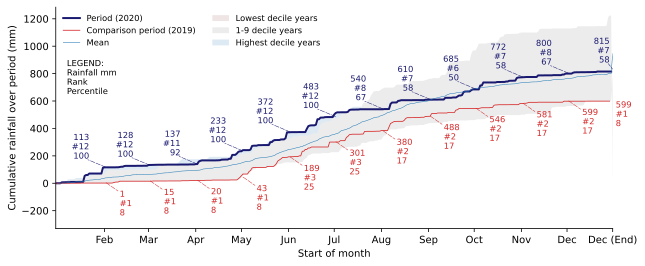

In [490]:
fig = Figure(figsize=(10, 4))
ax = fig.add_subplot(111)
year_days = days_in_year(year)
startmonths = startmonth_doys[year_days]
xticks = list(startmonths.values())
xtlabels = list(startmonths.keys())
pd_crain = pdf.cumsum(skipna=False)
prv_pd_crain = prv_pdf.cumsum(skipna=False)
xidx = np.arange(len(pd_crain))
prv_xidx = np.arange(len(prv_pd_crain))
ax.plot(xidx, pd_crain, lw=2, color='midnightblue', label=f"Period ({year})")
ax.plot(prv_xidx, prv_pd_crain, lw=0.8, color='tab:red', label=f"Comparison period ({comparison_year})")
ax.plot(mean_crain.index, mean_crain, lw=0.5, color='tab:blue', label="Mean")
ax.fill_between(low_yr_crains.index, low_yr_crains["min"], low_yr_crains["max"], color="tab:brown", lw=0, alpha=0.15, label="Lowest decile years")
ax.fill_between(low_yr_crains.index, low_yr_crains["max"], high_yr_crains["min"], color="grey", lw=0, alpha=0.15, label="1-9 decile years")
ax.fill_between(high_yr_crains.index, high_yr_crains["min"], high_yr_crains["max"], color="tab:blue", lw=0, alpha=0.15, label="Highest decile years")

ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
new_ymin = ymin - yrange / 5
ax.set_ylim(new_ymin, ymax)

for smonth, doy in startmonths.items():
    pd_val = pd_crain[doy - 1]
    if (doy == 366) and len(prv_pd_crain) < 366:
        prv_pd_val = prv_pd_crain[doy - 2]
    else:
        prv_pd_val = prv_pd_crain[doy - 1]
    high_y = np.nanmax([pd_val, prv_pd_val]) + yrange / 25
    low_y = np.nanmin([pd_val, prv_pd_val]) - yrange / 25
    
    if not np.isnan(pd_val):
        xoffset = 10
        tpt_yoffset = 5
        tpt_xoffset = 3
        ha = "left"
        ma = "left"
        va = "top"
        y = low_y
        if doy >= 365:
            y = pd_val
            xoffset = 2
        if pd_val > prv_pd_val:
            xoffset *= -1
            tpt_yoffset *= -1
            tpt_xoffset *= -1
            y = high_y
            ha = "right"
            ma = "right"
            va = "bottom"
        pt = (doy, pd_val)
        tpt = (doy + xoffset, y)
        rank = monthly_ranks[year].loc[smonth]
        pct = monthly_pcts[year].loc[smonth]
        label = f"{pd_val:.0f}\n#{rank:.0f}\n{pct:.0f}"
        ax.text(tpt[0], tpt[1], label, ha=ha, va=va, ma=ma, fontsize="small", color="midnightblue")
        ax.plot([pt[0] + 1, tpt[0] - 1], [pt[1] + 3, tpt[1] - tpt_yoffset], color='midnightblue', lw=0.5, dashes=(10, 2))
    
    if not np.isnan(prv_pd_val):
        xoffset = 10
        tpt_yoffset = 5
        tpt_xoffset = 3
        ha = "left"
        ma = "left"
        va = "top"
        y = low_y
        if doy >= 365:
            y = prv_pd_val
            xoffset = 2
        if prv_pd_val > pd_val:
            xoffset *= -1
            tpt_yoffset *= -1
            tpt_xoffset *= -1
            y = high_y
            ha = "right"
            ma = "right"
            va = "bottom"
        pt = (doy, prv_pd_val)
        tpt = (doy + xoffset, y)
        rank = monthly_ranks[comparison_year].loc[smonth]
        pct = monthly_pcts[comparison_year].loc[smonth]
        label = f"{prv_pd_val:.0f}\n#{rank:.0f}\n{pct:.0f}"
        ax.text(tpt[0], tpt[1], label, ha=ha, va=va, ma=ma, fontsize="small", color="tab:red")
        ax.plot([pt[0] + 1, tpt[0] - 1], [pt[1] + 3, tpt[1] - tpt_yoffset], color='tab:red', lw=0.5, dashes=(10, 2))

label = f"LEGEND:\nRainfall mm\nRank\nPercentile"
ax.text(0.02, 0.6, label, fontsize="small", transform=ax.transAxes, va="bottom", ha="left")
#     ax.annotate(smonth, (doy, pd_crain[doy - 1]), (doy + 15, pd_crain[doy - 1] - yrange / 10), arrowprops=dict(arrowstyle="-", ))

ax.set_xlim(xidx[0], max(len(pd_crain), len(mean_crain), len(median_crain)))
ax.set_xticks(xticks)
ax.set_xticklabels(xtlabels)
ax.set_xlabel("Start of month")

ax.set_ylabel("Cumulative rainfall over period (mm)")
ax.legend(loc="upper left", frameon=False, fontsize="small", ncol=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fn = f"test.svg"
canvas = FigureCanvasSVG(fig)
canvas.print_figure(fn, bbox_inches="tight")
display(SVG(fn))

In [491]:
pd_crain

yearday
(2020, 1)        0.0
(2020, 2)        0.0
(2020, 3)        0.0
(2020, 4)        0.0
(2020, 5)        6.8
               ...  
(2020, 362)    815.2
(2020, 363)    815.2
(2020, 364)    815.2
(2020, 365)    815.2
(2020, 366)    815.2
Name: rain_mm, Length: 366, dtype: float64

In [492]:
startmonths

{'Feb': 32,
 'Mar': 61,
 'Apr': 92,
 'May': 122,
 'Jun': 153,
 'Jul': 183,
 'Aug': 214,
 'Sep': 245,
 'Oct': 275,
 'Nov': 306,
 'Dec': 336,
 'Dec (End)': 366}

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


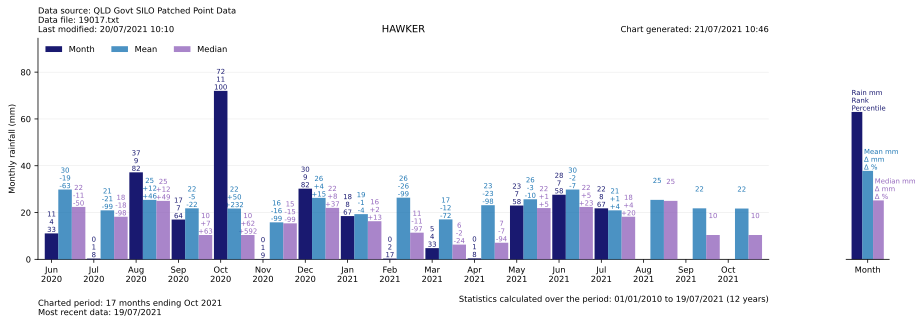

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


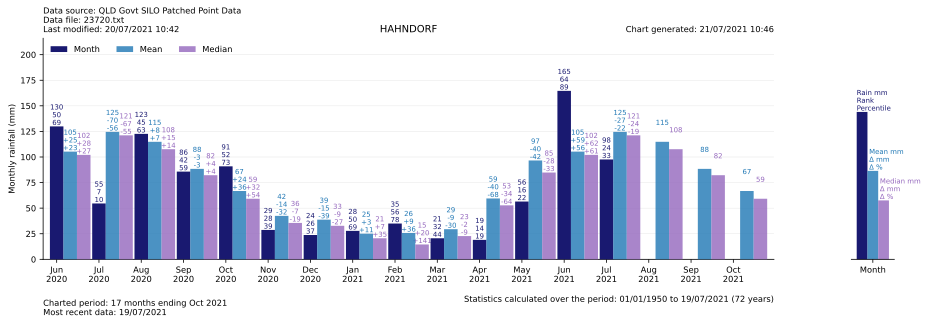

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


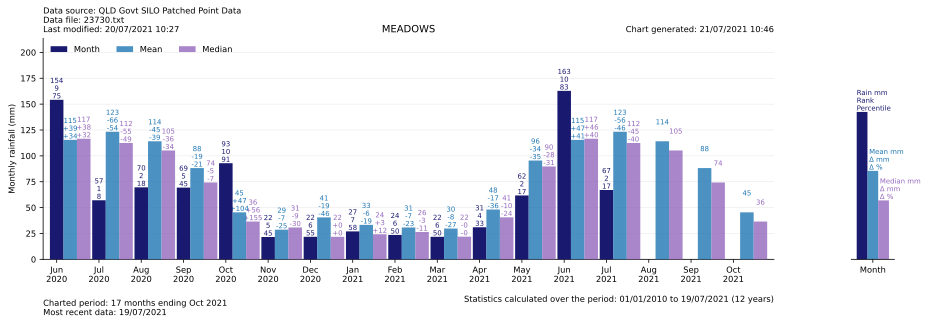

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


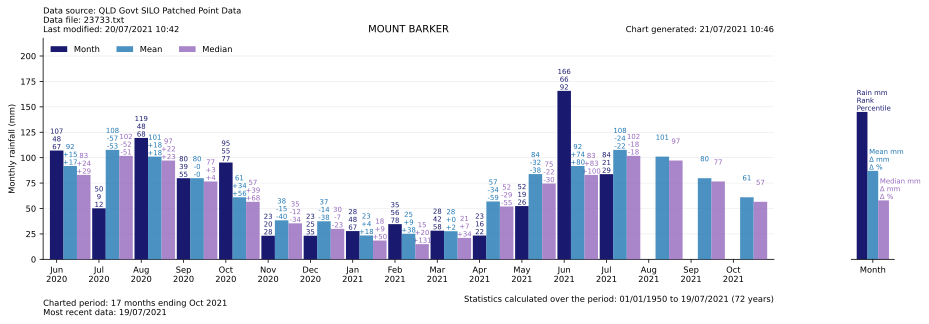

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


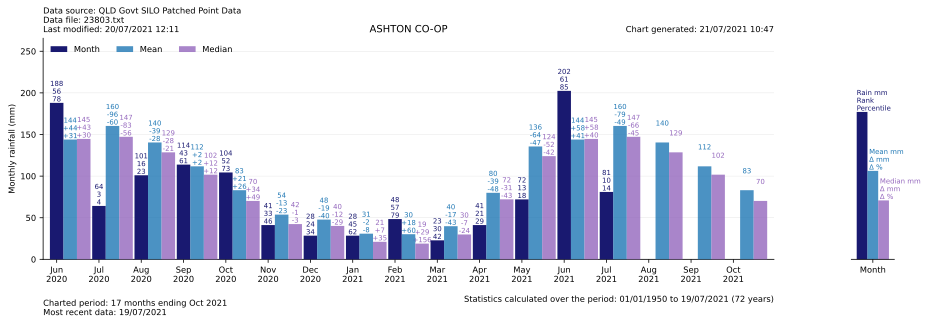

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


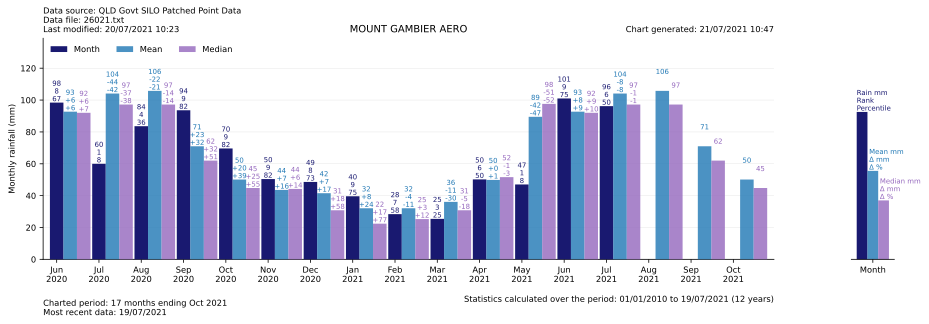

In [100]:
datasource = "QLD Govt SILO Patched Point Data"
for data_fn in Path(".").glob("*.txt"):
    rdf, station = read_siloppd_txt(data_fn)
    df = complete_rainfall_dataset(rdf)
    months, stats = make_monthly_data(df)
    monthly_ranks, monthly_pctls = calculate_monthly_ranks(months)
    period_label, period_data = get_n_months_prior((2021, 10), n=17)
    fig = monthly_chart(period_label, period_data, df, months, stats, station, data_fn)
    Path(station).mkdir(parents=True, exist_ok=True)
    fn = f"{station}/{station}__{period_label}.svg"
    canvas = FigureCanvasSVG(fig)
    canvas.print_figure(fn, bbox_inches='tight')
    display(SVG(fn))